<a href="https://colab.research.google.com/github/jinensetpal/evalita/blob/master/reports/report_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Report 2: DANKMEMES - Updated Run**

Loading Resources to Workspace - 

> This code is not functional, and only contains relevant snippets for functions implemented to the main code -
https://github.com/jinensetpal/evalita/blob/master/approaches/augmented_backpropgation.ipynb. 

In [ ]:
! pip install -q tensorflow numpy pandas scikit-learn transformers
! cp drive/My\ Drive/Colab\ Notebooks/*.csv ./
! cp drive/My\ Drive/Colab\ Notebooks/*.pkl ./

# **Implemented Changes**


## **Prior Suggestions**


### **Binary Field**

Convert OneHot Encoding to Binary Field that does not represent user sets as a separate entity

In [ ]:
def create_map():
  temp = df[['Visual']].values
  counter = 0
  map = {}
  for i in temp:
    for j in i[0].split():
      if j.strip(',') not in map and j.strip(',') != '0':
        map[j.strip(',')] = counter
        counter += 1
  return map

In [ ]:
def ohe(map):
  one_hot_encode = []
  temp = df[['Visual']].values

  for i in temp:
    arr = list(np.zeros(len(map),dtype=int))
    for j in i[0].split():
      if j.strip(',') != '0':
        arr[map[j.strip(',')]] = 1
    one_hot_encode.append(arr)
  return np.array(one_hot_encode)

In [ ]:
temp = ohe(create_map())
print(temp.shape)
X = np.hstack((X, temp)) ## Added parameter to dataset
print(X.shape)

### **Manipulation**

Removed the Manipulation parameter

## **Backpropogation using GradientTape**

Backpropogating algorithm implemented targeted towards loss reduction.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
    self.drop = tf.keras.layers.Dropout(rate=0.5)
    self.dense2 = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
    self.dense3 = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
    self.dense4 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)
    self.dense5 = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) 

  def call(self, x):
    x = self.dense1(x)
    x = self.drop(x)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)
    return self.dense5(x)

model = MyModel()

In [ ]:
@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.RMSprop()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

## **BERT Embeddings**

As advised, obtained BERT Embeddings to leverage NLP on the task. However, when run in an isolated environment to analyse individual prediction performance, it predicted poorly. A review to identify the error, in embedding or implementations would be greatly appreciated!

> Code Reference https://github.com/jinensetpal/evalita/blob/master/BERT/bert_embeddings.ipynb

## **Image Augmentation**

In order to improve generalization score, testing images were augmented, randomly modifying images in to prevent overfitting of the model to orientation of image features. Below is a sample for a single image - this has been implemented throughout for every single, image. The testing dataset increased to 10x the original size due to this change.

> The current run has been unsuccessful, probably on account of vector representations \[see next\] and incorrect parameters. A new set is currently being run with updated characteristics.

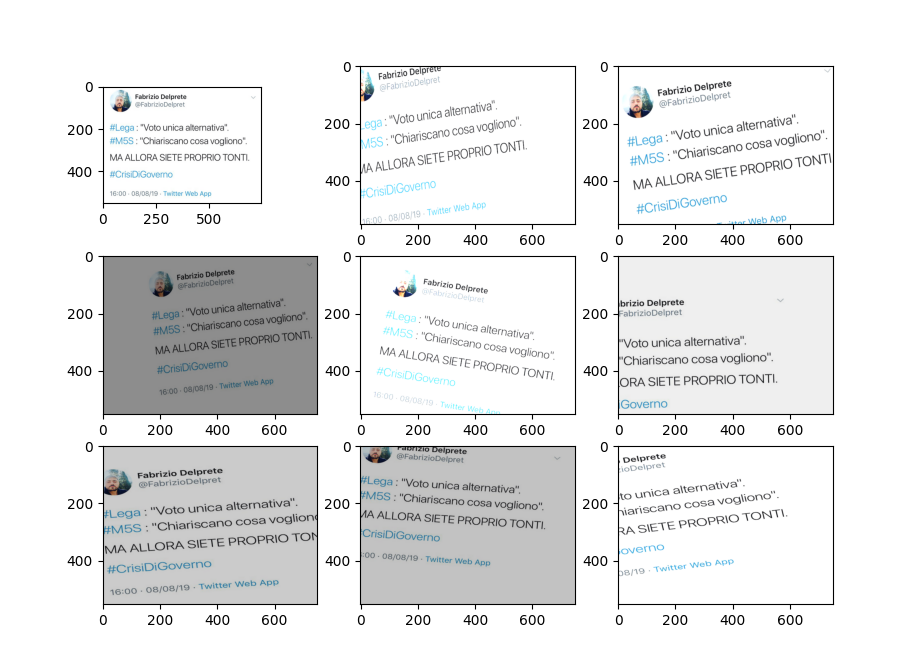

In [ ]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img, ImageDataGenerator
import matplotlib.pyplot as plt

img = load_img('../images/1500.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
gen = ImageDataGenerator(brightness_range=[0.3, 1.7],
                         rotation_range=10,
                         zoom_range=[0.8, 1.2],
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         fill_mode="nearest")
it = gen.flow(samples, batch_size=1)
for i in range(9):
    print("Collecting: Image", i)
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
    save_img('image.jpg', image)
    print("Augmented: Image", i)
plt.subplot(330 + 1 + 10)
plt.imshow(img)
plt.show()
plt.savefig('augmented_sample.png')

## **ResNeSt Embeddings**

The newly augmented images had to be unified with the older images. Therefore the dataset was converted completely to the new SOTA ResNeSt embeddings for vector representation. The only downside with the model is that is provides an output vector of dimensions (1,1000), which causes a decrease in feature representation impacting model performance.

Reference - https://arxiv.org/abs/2004.08955

In [ ]:
from PIL import Image
from torchvision import transforms

def resnet(filename):
  input_image = Image.open(filename + '.jpg').convert('RGB') # To prevent multi-channel conflict
  preprocess = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # mean/std using default values
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) 
  input_batch = input_batch.to('cuda')
  model.to('cuda')
  with torch.no_grad():
    output = model(input_batch)
  return torch.nn.functional.softmax(output[0], dim=0).cpu().numpy()

# **Result Analysis**

- Prior Suggestions collectively caused an increase in validation accuracy by 5%
- Backpropogation caused minor differences over feedforward algorithm; hence both approaches are used for each implementation
- BERT Embeddings predicting poorly; currently reviewing process
- Image Augmentation requires tuning for greater predictability; updated run underway
- ResNeSt Embeddings underperforming original vector representations; new embeddings with feature vector of dimensions (1,2048) or (1,4096) being prepared for next batch of augmented images